# GLCM

### Mikel Ignacio Barajas Martínez

Ingeniería en Sistemas Inteligentes, 2021, 336483, 202102300012 \

### 03/22/24

𝝮

## Texture

Everyday texture terms - rough, silky, bumpy - refer to touch. They are most easily understood in relation to a topographical surface with high and low points, and a scale compatible with a finger or other.

Image texture works in the same way, except the highs and lows are brightness values (also called grey levels, GL, or digital numbers, DN) instead of elevation changes. Instead of probing a fingertip over the surface, a "window" - a square box defining the size of the probe - is used. And, of course, the scale (pixel size) is not necessarily that of a fingertip, but may be defined however is convenient for the image data available.

Textures in images quantify:
- Grey Level differences (contrast)
- Defined size of area where change occurs (neighbourhood, defined by a window size)
- Directionality, or lack of it (omnidirectional)


## GLCM

Tabulation of how often different combinations of pixel brightness values (grey levels) occur in an image. GLCMs are used for a series of "second order" texture calculations.

> Second order means they consider the relationship between groups of two pixels in the original image.

> First order texture measures are statistics calculated from the original image values, like variance, and do not consider pixel relationships.

GLCM texture considers the relation between two pixels at a time, called the reference and the neighbour pixel. All pixels can serve as reference and neighbour pixels.

the GLCM is constructed by counting and tabulating the number of pixel pairs that show a combination of all possible GL value pairs. The GLCM entries are counts of frequencies of the neighbouring pairs of image pixel values

Matrix:

\begin{align}
\begin{bmatrix}
0 & 0 & 1 & 1\\
0 & 0 & 1 & 1\\
0 & 2 & 2 & 2\\
2 & 2 & 3 & 3
\end{bmatrix}
\end{align}


GLCM with spatial relationship (1,0):

| R/N    | 0 | 1 | 2 | 3 |
| --- | --- | --- | --- | --- |
| 0 | 2 | 2 | 1 | 0 |
| 1 | 0 | 2 | 0 | 0 |
| 2 | 0 | 0 | 3 | 1 |
| 3 | 0 | 0 | 0 | 1 |

>Twice in the test image the reference pixel has the value of 0 and its eastern neighbour is also 0. Twice the reference pixel is 0 and its eastern neighbour is 1. Three times the reference pixel is 2 and its neighbour is also 2.


### Properties

- **Square matrix**
- **Quantization level**: It has the same number of rows and columns as the quantization level of the image

    - The test image is 2-bit has four (2 2 ) grey level values (0,1,2 and 3). Eight bit data has 256 possible values (2 8 ), so would yield a 256 x 256 square matrix, with 65,536 cells. 16 bit data would give a matrix of size 65536 x 65536 = 429,496,720 cells!

$\therefore$ Dicom may be an issue given the 16-bit depth

### Symmetry

- **Preferably symmetrical**

- same values occur in cells on opposite sides of the diagonal.

- Symmetry will be achieved if each pixel pair is counted twice: once "forwards" and once "backwards" (interchanging reference and neighbour pixels for the second count)

// Just add the transpose, do not double count

### Probability

The simplest definition of the probability of a given outcome is "the number of times this outcome occurs, divided by the total number of possible outcomes." We can use the GLCM to express probability (likelihood of finding a combination of (x,y)) by normalizing:

\begin{align}
    P_{ij} = \frac{V_{ij}}{\sum_{i,j}^{N-1} V_{ij}}
\end{align}


### Steps so far

1. Create a framework matrix taking into account the bit depth
2. Decide on the spatial relation between the reference and neighbour pixel
3. Count the occurrences and fill in the framework matrix
4. Add the matrix to its transpose to make it symmetrical
5. Normalize the matrix to conceptually turn it into probabilities.


### Notes

- The farther away from the diagonal, the greater the difference between pixel grey levels.

- The diagonal elements all represent pixel pairs with no grey level difference. If probabilities are high in the diagonal, contrast is low.

## Texture Measures

Texture measures are the various single values used to summarize the normalized symmetrical GLCM in helpful ways. These are the things most often referenced in the literature: “Contrast”;
“Dissimilarity”; “Entropy” etc. There are several of them because each summarizes in a different way, allowing choice to fit the problem at hand.

Most texture measure calculations are weighted averages of the normalized GLCM cell contents.

> A weighted average multiplies each value to be used by a factor (a weight) before summing and dividing by the number of values. The weight is intended to express the relative importance of the value.

## Example

the Dissimilarity is a way to measure contrast. Weights increase linearly as it moves away from the diagonal.

The Correlation texture measures the linear dependency of grey levels on those of
neighbouring pixels.

> Correlation between pixels means that there is a predictable and linear relationship between the two neighbouring pixels within the window, expressed by the regression equation.

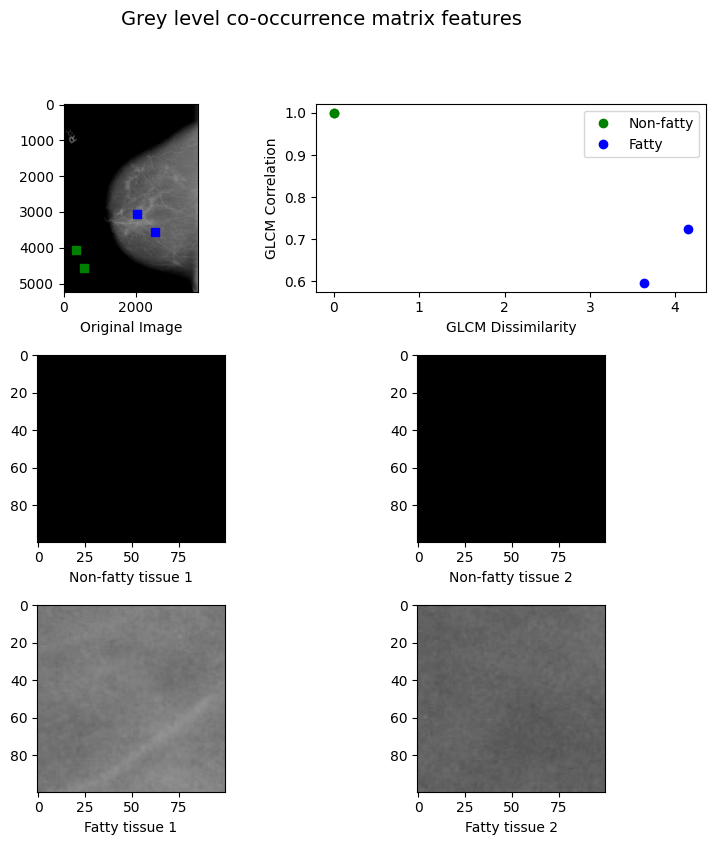

In [1]:
# example from science kit image, better texture measures should be chosen

import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops
from skimage import data, io


PATCH_SIZE = 100

# open the camera image
image = io.imread('CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.499558611862523307025745211397332529/1-036.jpg') # from CBIS-DDSM

# select some patches from non-fatty areas of the image
nf_locations = [(4000, 300), (4500, 500)]
nf_patches = []
for loc in nf_locations:
    nf_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from fatty areas of the image
f_locations = [(3000, 2000), (3500, 2500)]
f_patches = []
for loc in f_locations:
    f_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
for patch in (nf_patches + f_patches):
    glcm = graycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    # print(glcm)
    xs.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(graycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in nf_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in f_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(nf_patches)], ys[:len(nf_patches)], 'go',
        label='Non-fatty')
ax.plot(xs[len(nf_patches):], ys[len(nf_patches):], 'bo',
        label='Fatty')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(nf_patches):
    ax = fig.add_subplot(3, len(nf_patches), len(nf_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel(f"Non-fatty tissue {i + 1}")

for i, patch in enumerate(f_patches):
    ax = fig.add_subplot(3, len(f_patches), len(f_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel(f"Fatty tissue {i + 1}")


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

## Referencias

https://www.mathworks.com/help/images/texture-analysis-using-the-gray-level-co-occurrence-matrix-glcm.html

http://lapi.fi-p.unam.mx/wp-content/uploads/Tutorial-GLCM.pdf



## Extra

https://www.tandfonline.com/doi/abs/10.1080/01431161.2016.1278314

